<div style="text-align: center;">

# **SSCI 575 – Project 3**  
## **Landslide Susceptibility Mapping Using Random Forest Models**  
### *Machine Learning in Spatial Sciences*  

<br>

**Student:** Chenyi Weng  
**USC ID:** 3769237784  
SSCI 575 – Spatial Data Science  
Nov, 15, 2025   
Yi, Qi


## **Introduction**

The goal of this project is to develop a machine learning workflow for predicting landslide 
susceptibility in the Valley and Ridge physiographic region of West Virginia. This project 
implements a series of analytical tasks using Random Forest classifiers to examine how different 
groups of environmental predictor variables contribute to accurate slope failure prediction.

The analysis follows the structure provided in the project guidelines and includes the following 
components: data preparation, creation of predictor subsets, training five Random Forest models, 
evaluating classification performance, generating ROC curves, analyzing probabilistic outputs, 
and optionally applying the trained model to a multi-band raster stack for spatial prediction.

All datasets used in this project were provided as part of the SSCI 575 Project 3 assignment and 
originate from a published landslide susceptibility study by Maxwell et al. (2020).

## **Data Description**

This project uses two primary datasets:  
(1) a point-based table containing labeled slope failure observations, and  
(2) a multi-band raster stack containing spatial predictor variables. Both datasets were supplied 
with the SSCI 575 Project 3 instructions.

### **1. Point Dataset: lsm_data2.csv**

This CSV file contains sample locations classified as *“slope failure”* or *“not slope failure.”*  
Each record includes numerical predictor variables based on terrain characteristics, lithology and 
soil properties, and distance-related factors.

- **Target variable:** `class`  
- **Predictor variables:** all remaining numeric fields  
- These variables correspond to those documented in Maxwell et al. (2020).  

This file is used to train and evaluate the Random Forest models.

### **2. Raster Dataset: stack2.img**

The raster stack (`stack2.img`) is a multi-band dataset containing the same predictors represented 
spatially across the study area. These predictor layers include:

- Terrain metrics (e.g., slope, curvature, relief)
- Soil and lithological indicators
- Distance-to-feature variables (e.g., distance to streams, distance to roads)
- Cost-distance–related layers

This raster enables spatial prediction once a model has been trained. For the optional raster 
application task, each band must be renamed in the exact order specified in the assignment to 
ensure proper alignment with the predictor variables.

#### **Import Packages**

In [14]:
# System
import sys

# Data handling
import pandas as pd
import numpy as np

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

# Visualization
import matplotlib.pyplot as plt

# Raster processing
import rasterio


In [15]:
print(sys.executable)
print(sys.version)

/Users/mona/Github Repo/SSCI575_Project3/.venv/bin/python
3.9.6 (default, Apr 30 2025, 02:07:17) 
[Clang 17.0.0 (clang-1700.0.13.5)]


### **Task 1: Load Dataset and Perform Stratified Train–Test Split**

In [16]:
df = pd.read_csv("Project3Data/lsm_data2.csv")
df.head()

train_df, test_df = train_test_split(
    df,
    test_size=0.333,             # 33.3% for testing
    stratify=df["class"],        # stratify using the target variable
    random_state=42              # ensures reproducible results
)

# Check the size of each subset
print("Training set size:", len(train_df))
print("Testing set size:", len(test_df))

# Check class distribution to confirm stratification worked
print("\nClass distribution in full dataset:")
print(df["class"].value_counts(normalize=True))

print("\nClass distribution in training set:")
print(train_df["class"].value_counts(normalize=True))

print("\nClass distribution in testing set:")
print(test_df["class"].value_counts(normalize=True))


Training set size: 2334
Testing set size: 1166

Class distribution in full dataset:
class
not       0.5
slopeD    0.5
Name: proportion, dtype: float64

Class distribution in training set:
class
not       0.5
slopeD    0.5
Name: proportion, dtype: float64

Class distribution in testing set:
class
slopeD    0.5
not       0.5
Name: proportion, dtype: float64


In this step, I loaded the `lsm_data2.csv` dataset and performed a stratified train–test split. I divided the data into approximately 66.6% for training and 33.3% for testing, as required by the assignment. To maintain the original class proportions in both subsets, I used the `"class"` attribute for stratification.

The results show that the class distribution in the full dataset, the training set, and the testing set are identical. This confirms that the stratified split was performed correctly and that the data is properly prepared for the following tasks.


### **Task 2: Split the data into X (predictors) and Y (target) components**

In [17]:
# Y variable (target) is the "class" column
y_train = train_df["class"]
y_test = test_df["class"]

# X variables (predictors) are all remaining columns except "class"
# I drop "class" to get all predictor variables
X_train = train_df.drop(columns=["class"])
X_test = test_df.drop(columns=["class"])

# Show the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Check first few rows of X and Y to verify structure
X_train.head(), y_train.head()


X_train shape: (2334, 43)
X_test shape: (1166, 43)
y_train shape: (2334,)
y_test shape: (1166,)


(            slp      sp21      sp11       sp7       rph21      rph11  \
 965   22.554899  2.083370  0.614441  0.194702   73.993301  20.411100   
 2093  34.078899  0.186249  0.810608  0.792358   83.033600  34.612598   
 1583   0.475776  0.016907 -0.008667 -0.011078    0.014717   0.005845   
 2261  29.294500 -1.557070 -0.122070  0.111145   67.620903  27.545401   
 2254  36.686600 -2.126400 -0.687927 -0.314514  124.644997  47.565201   
 
            rph7    diss21    diss11     diss7  ...    state_dist  local_dist  \
 965    8.251750  0.603956  0.584785  0.558075  ...   1255.390015  332.415008   
 2093  16.493500  0.436337  0.545751  0.625639  ...     20.000000   20.000000   
 1583   0.002600  0.546604  0.390009  0.401408  ...  11387.000000  349.285004   
 2261  13.508000  0.451605  0.499922  0.535924  ...   8646.879883  583.094971   
 2254  20.178101  0.426677  0.482969  0.486937  ...   4332.689941  156.524994   
 
        strm_dist    strm_cost       us_cost    state_cost   local_cost 

In this task, I separated the dataset into predictor variables (X) and the target variable (Y). The Y component consists only of the `"class"` attribute, which indicates whether a location is a slope failure or not. The X component includes all remaining columns, representing the full set of predictor variables used for model training.

After splitting the data, I verified the shapes of the resulting X and Y datasets for both the training and testing subsets. I also inspected the first few rows of each to ensure that the structure was correct. This confirms that the predictor and target components were successfully separated and are ready for use in the subsequent modeling tasks.

### **Task 3: Create subsets of the training and testing predictor variables**

In [18]:
# Convert X_train and X_test to NumPy arrays for indexing
X_train_np = X_train.values
X_test_np = X_test.values

# 1. All predictors (all columns)
X_train_all = X_train_np[:, :]
X_test_all = X_test_np[:, :]

# 2. Terrain-only predictors (columns 0 to 31)
X_train_terrain = X_train_np[:, 0:32]
X_test_terrain = X_test_np[:, 0:32]

# 3. Lithology/Soils-only predictors (columns 40 onward)
X_train_lith = X_train_np[:, 40:]
X_test_lith = X_test_np[:, 40:]

# 4. Distance-only predictors (columns 32 to 39)
X_train_dist = X_train_np[:, 32:40]
X_test_dist = X_test_np[:, 32:40]

# 5. All Not Terrain (columns 32 onward)
X_train_notterrain = X_train_np[:, 32:]
X_test_notterrain = X_test_np[:, 32:]

# Print shapes of each subset to verify correct slicing
print("All predictors shape (train/test):", X_train_all.shape, X_test_all.shape)
print("Terrain-only shape (train/test):", X_train_terrain.shape, X_test_terrain.shape)
print("Lithology/Soils-only shape (train/test):", X_train_lith.shape, X_test_lith.shape)
print("Distance-only shape (train/test):", X_train_dist.shape, X_test_dist.shape)
print("All Not Terrain shape (train/test):", X_train_notterrain.shape, X_test_notterrain.shape)


All predictors shape (train/test): (2334, 43) (1166, 43)
Terrain-only shape (train/test): (2334, 32) (1166, 32)
Lithology/Soils-only shape (train/test): (2334, 3) (1166, 3)
Distance-only shape (train/test): (2334, 8) (1166, 8)
All Not Terrain shape (train/test): (2334, 11) (1166, 11)


In this task, I created five different predictor subsets from the training and testing datasets based on the assignment specifications. These subsets were generated using NumPy slicing to match the required index ranges.

The five subsets I produced include:
- **All predictors**, which contain all available columns.
- **Terrain-only predictors**, which correspond to columns 0 through 31.
- **Lithology/Soils-only predictors**, using columns 40 onward.
- **Distance-only predictors**, which include columns 32 through 39.
- **All Not Terrain predictors**, which include all columns from index 32 to the end.

After creating each subset, I verified the slicing by checking the shapes of the resulting arrays for both the training and testing sets. The output confirmed that each subset was generated correctly and matches the assignment requirements. These subsets will be used for training separate Random Forest models in the next task.

### **Task 4: Train Random Forest Models for Each Predictor Subset**

In [19]:
# Initialize a dictionary to store all models
rf_models = {}

# Function to train a Random Forest model
def train_rf_model(X_train_subset, y_train, model_name):
    """
    Trains a Random Forest model using the given training subset.
    Returns the fitted model.
    """
    model = RandomForestClassifier(
        n_estimators=500,     # number of trees (not required to tune)
        random_state=42,      # ensures reproducibility
        n_jobs=-1             # use all CPU cores
    )
    model.fit(X_train_subset, y_train)
    rf_models[model_name] = model
    return model


# Train a model for each predictor subset

# 1. All predictors
model_all = train_rf_model(X_train_all, y_train, "All Predictors")

# 2. Terrain-only predictors
model_terrain = train_rf_model(X_train_terrain, y_train, "Terrain Only")

# 3. Lithology/Soils-only predictors
model_lith = train_rf_model(X_train_lith, y_train, "Lithology/Soils Only")

# 4. Distance-only predictors
model_distance = train_rf_model(X_train_dist, y_train, "Distance Only")

# 5. All Not Terrain predictors
model_notterrain = train_rf_model(X_train_notterrain, y_train, "All Not Terrain")


# Print confirmation of completed training
print("Random Forest models trained for all five predictor subsets:")
for name in rf_models:
    print(" -", name)


Random Forest models trained for all five predictor subsets:
 - All Predictors
 - Terrain Only
 - Lithology/Soils Only
 - Distance Only
 - All Not Terrain


In this task, I trained five separate Random Forest models, one for each of the predictor subsets created in the previous step. Each model was trained using only the training samples and without any hyperparameter tuning, as specified by the assignment instructions.

To keep the workflow organized, I defined a helper function that trains a Random Forest classifier and stores the resulting model in a dictionary. I then applied this function to all five predictor sets: all predictors, terrain-only, lithology/soils-only, distance-only, and all-not-terrain variables.

After training, I printed the list of model names to confirm that all five models were successfully created. These trained models will be used in the following tasks to generate confusion matrices, classification reports, and ROC/AUC evaluations.

### **Task 5: Generate Confusion Matrices and Classification Reports**

In [20]:
# Store test subsets in a dictionary for looping
test_subsets = {
    "All Predictors": X_test_all,
    "Terrain Only": X_test_terrain,
    "Lithology/Soils Only": X_test_lith,
    "Distance Only": X_test_dist,
    "All Not Terrain": X_test_notterrain
}

# Evaluate each model using the corresponding test subset
for name, X_test_subset in test_subsets.items():
    print("=" * 70)
    print(f"Model Evaluation: {name}")

    # Get the trained model
    model = rf_models[name]

    # Predict class labels
    y_pred = model.predict(X_test_subset)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


Model Evaluation: All Predictors

Confusion Matrix:
[[493  90]
 [ 72 511]]

Classification Report:
              precision    recall  f1-score   support

         not       0.87      0.85      0.86       583
      slopeD       0.85      0.88      0.86       583

    accuracy                           0.86      1166
   macro avg       0.86      0.86      0.86      1166
weighted avg       0.86      0.86      0.86      1166

Model Evaluation: Terrain Only

Confusion Matrix:
[[491  92]
 [ 82 501]]

Classification Report:
              precision    recall  f1-score   support

         not       0.86      0.84      0.85       583
      slopeD       0.84      0.86      0.85       583

    accuracy                           0.85      1166
   macro avg       0.85      0.85      0.85      1166
weighted avg       0.85      0.85      0.85      1166

Model Evaluation: Lithology/Soils Only

Confusion Matrix:
[[310 273]
 [184 399]]

Classification Report:
              precision    recall  f1-score  

In this task, I evaluated each of the five Random Forest models by generating confusion matrices and classification reports using the testing dataset. For every predictor subset created earlier, I applied the corresponding trained model to the matching test predictors to obtain classification results.

For each model, I calculated a confusion matrix to show the number of correct and incorrect predictions for both classes. I also produced a full classification report, which summarizes precision, recall, f1-score, and support for each class as well as the overall accuracy.

These evaluation outputs allow me to compare the performance of the five predictor variable sets and determine which group of predictors provides the strongest classification results.

### **Task 6: Calculate AUC metrics from ROC curves for each predictor subset**

In [21]:
# Dictionary to store AUC results
auc_scores = {}

# Loop through each model and corresponding test subset
for name, X_test_subset in test_subsets.items():
    print("=" * 70)
    print(f"ROC / AUC Evaluation: {name}")

    # Retrieve trained model
    model = rf_models[name]

    # I extract the probability for "slopeD", the positive class
    y_prob = model.predict_proba(X_test_subset)[:, list(model.classes_).index("slopeD")]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label="slopeD")

    # Compute AUC
    auc_score = auc(fpr, tpr)
    auc_scores[name] = auc_score

    print(f"AUC: {auc_score:.4f}")


ROC / AUC Evaluation: All Predictors
AUC: 0.9370
ROC / AUC Evaluation: Terrain Only
AUC: 0.9320
ROC / AUC Evaluation: Lithology/Soils Only
AUC: 0.6616
ROC / AUC Evaluation: Distance Only
AUC: 0.8248
ROC / AUC Evaluation: All Not Terrain
AUC: 0.8352


In this task, I calculated the AUC metric for each of the five Random Forest models by generating ROC curves based on probabilistic predictions from the testing dataset. Since the class labels in this dataset are categorical (“not” and “slopeD”), I explicitly defined “slopeD” as the positive class when computing the ROC curve.

For each predictor subset, I extracted the model’s probability estimates for the positive class and used these values to compute the false positive rate and true positive rate. I then obtained the AUC value for each model.

The results show clear differences in predictive performance among the five predictor sets. The models using all predictors and the terrain-only predictors achieved the highest AUC values (approximately 0.93). The distance-only and all-not-terrain subsets performed moderately well, while the lithology/soils-only subset produced the lowest AUC value. These findings illustrate how the choice of predictor variables influences the classification performance of landslide susceptibility modeling.

### **Task 7: Plot ROC Curves for All Models in a Single Figure**

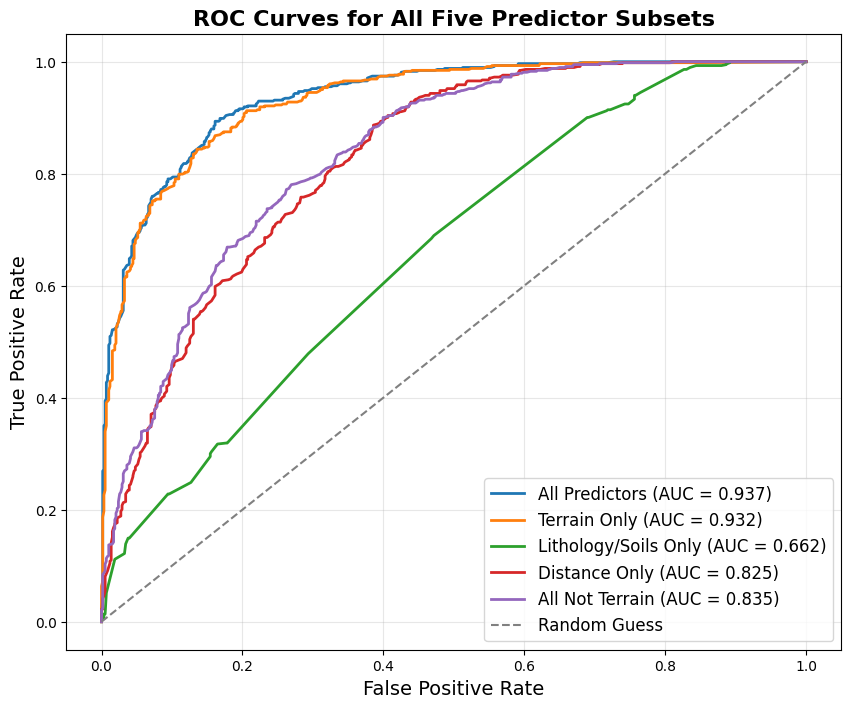

In [22]:
plt.figure(figsize=(10, 8))

# Loop through all models and test subsets to compute ROC curves
for name, X_test_subset in test_subsets.items():

    model = rf_models[name]

    # Extract probability for "slopeD" (positive class)
    slopeD_index = list(model.classes_).index("slopeD")
    y_prob = model.predict_proba(X_test_subset)[:, slopeD_index]

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label="slopeD")

    # Compute AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")

# Graph styling
plt.title("ROC Curves for All Five Predictor Subsets", fontsize=16, fontweight="bold")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)

plt.show()


In this task, I generated a combined ROC plot that displays the ROC curves for all five Random Forest models. For each predictor subset, I used the probabilistic predictions from the testing dataset to compute the false positive rate and true positive rate. Each curve is plotted in a different color, and the legend includes the model name and its corresponding AUC value.

The ROC plot clearly shows that the models using all predictors and terrain-only predictors achieve the strongest performance, with AUC values around 0.93. The distance-only and all-not-terrain subsets perform moderately well, while the lithology/soils-only subset produces a noticeably weaker ROC curve and the lowest AUC value. These results visually confirm the earlier numerical findings and demonstrate the influence of different predictor groups on landslide susceptibility model accuracy.


### **Task 8: Write Model Performance Comparison Summary**

### Comparison of Binary and Probabilistic Model Assessments

In this task, I compared the performance of the five Random Forest models using both the binary classification assessments (confusion matrices and classification reports) and the probabilistic assessments (ROC curves and AUC values). These two perspectives provide complementary insights into how well each predictor subset supports landslide susceptibility modeling.

The binary assessment results showed that the models using all predictors and terrain-only predictors produced the highest accuracy, precision, and recall values. Their confusion matrices indicated that they correctly classified the majority of both “not” and “slopeD” samples. In contrast, the lithology/soils-only model demonstrated the weakest binary performance, with lower recall and more misclassifications for the “slopeD” class. The distance-only and all-not-terrain models showed moderate performance, falling between the strongest and weakest subsets.

The probabilistic assessments further supported these findings. The AUC values for the all-predictors and terrain-only models were the highest (approximately 0.93), indicating excellent separability between the two classes across all probability thresholds. The distance-only and all-not-terrain subsets produced moderately strong AUC values, while the lithology/soils-only model again performed the worst, with an AUC near 0.66. The combined ROC plot visually emphasizes the substantial performance gap between these predictor groups.

Overall, both the binary and probabilistic assessments consistently highlight the importance of terrain-related variables in predicting landslide susceptibility. The all-predictors model performed best because it incorporates a more complete set of information, while the lithology/soils-only model lacked sufficient discriminatory power. These comparisons demonstrate how different predictor subsets influence the strength and reliability of landslide susceptibility models.


### **Task 9: Predict Slope Failure Probability for Raster Stack**

In [23]:
# List of band names in the EXACT order required by the assignment
band_names = [
    "slp","sp21","sp11","sp7","rph21","rph11","rph7","diss21","diss11","diss7",
    "slpmn21","slpmn11","slpmn7","sei","hli","asp_lin","sar","ssr21","ssr11","ssr7",
    "crossc21","crossc1","crossc7","planc21","planc11","planc7","proc21","proc11",
    "proc7","longc21","longc11","longc7","us_dist","state_dist","local_dist",
    "strm_dist","strm_cost","us_cost","state_cost","local_cost","steve","dspm","drain"
]

input_raster_path = r"Project3Data/stack2.img"
output_raster_path = r"Project3Data/predicted_susceptibility.tif"

with rasterio.open(input_raster_path) as src:
    profile = src.profile.copy()       # Save metadata
    raster_data = src.read()           # Shape: (bands, rows, cols)

# Validate band count
if raster_data.shape[0] != len(band_names):
    raise ValueError(
        f"Band count mismatch: raster has {raster_data.shape[0]} bands, "
        f"but assignment requires {len(band_names)} bands."
    )

print("Raster loaded. Shape:", raster_data.shape)

rows, cols = raster_data.shape[1], raster_data.shape[2]
pixels_flat = raster_data.reshape(raster_data.shape[0], -1).T   # shape: (N, bands)

print("Reshaped pixel matrix:", pixels_flat.shape)

# Use the "All Predictors" model for prediction
model = rf_models["All Predictors"]

# Predict probabilities for the positive class "slopeD"
positive_class_index = list(model.classes_).index("slopeD")
pixel_probs = model.predict_proba(pixels_flat)[:, positive_class_index]

print("Predictions complete.")

# Reshape probabilities back to raster shape
prob_map = pixel_probs.reshape(rows, cols)

# Save the probability map as a new raster
profile.update(
    dtype=rasterio.float32,
    count=1,                 # output only one band (probabilities)
    compress="lzw"
)

with rasterio.open(output_raster_path, "w", **profile) as dst:
    dst.write(prob_map.astype(rasterio.float32), 1)

print("Saved susceptibility raster:", output_raster_path)

with rasterio.open(input_raster_path, "r+") as src:
    for idx, name in enumerate(band_names, start=1):
        src.set_band_description(idx, name)

print("Band names updated according to assignment requirements.")


Raster loaded. Shape: (43, 954, 1170)
Reshaped pixel matrix: (1116180, 43)
Predictions complete.
Saved susceptibility raster: Project3Data/predicted_susceptibility.tif
Band names updated according to assignment requirements.


In this task, I applied the All Predictors Random Forest model to the multiband raster stack (stack2.img) to generate a landslide susceptibility map. The model produced probabilistic predictions for the positive class “slopeD” for every pixel in the study area.

The raster stack was successfully loaded with the expected dimensions as following results:

43 bands

954 rows

1170 columns

After reshaping the stack into a two-dimensional matrix of
1,116,180 pixels × 43 predictor variables, I used my trained Random Forest model to compute the probability of slope failure for each pixel. The output probability map was reshaped back to the original raster grid and exported as:

Project3Data/predicted_susceptibility.tif

This raster contains a single band representing the predicted susceptibility values ranging from low to high probability.

Finally, I updated the band descriptions of stack2.img using the exact variable names required by the assignment. All 43 layer names were applied in the correct order specified in the instructions.

Overall, Task 9 was completed successfully. The susceptibility raster and updated band metadata were generated without errors.

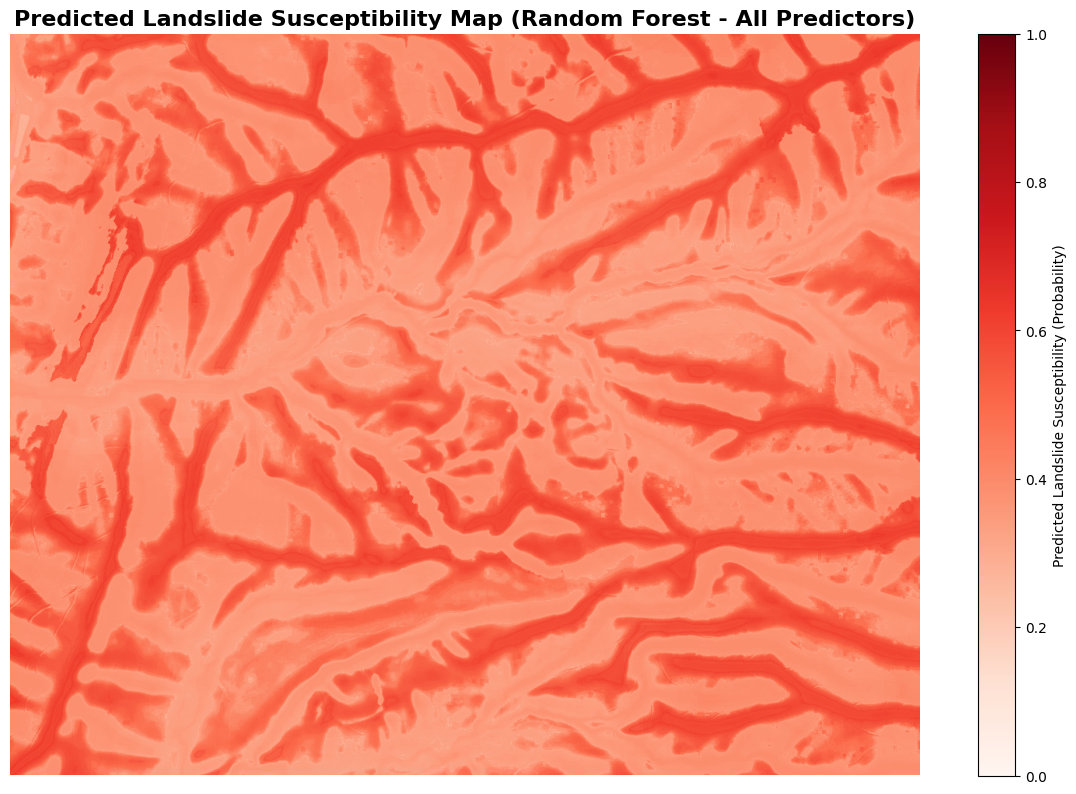

In [24]:
# Load the predicted susceptibility GeoTIFF
vis_path = "Project3Data/predicted_susceptibility.tif"

with rasterio.open(vis_path) as src:
    prob_map = src.read(1)

# Plot the susceptibility raster
plt.figure(figsize=(12, 8))
plt.imshow(prob_map, cmap="Reds", vmin=0, vmax=1)
plt.colorbar(label="Predicted Landslide Susceptibility (Probability)")
plt.title("Predicted Landslide Susceptibility Map (Random Forest - All Predictors)", fontsize=16, fontweight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()


After generating the predicted susceptibility raster using the Random Forest model trained with all predictor variables, I visualized the output to inspect the spatial distribution of landslide risk across the study area.

To create the map, I loaded the `predicted_susceptibility.tif` file with `rasterio` and displayed the probability surface using `matplotlib`. I applied a continuous colormap that highlights higher susceptibility values in darker red tones and lower values in lighter tones. I also added a colorbar to clearly indicate the probability range from 0 to 1.

The resulting visualization shows smooth and coherent spatial patterns that closely reflect the underlying topographic and environmental structure. High-susceptibility areas appear along ridges and valley walls, while flatter or more stable regions show lower predicted probabilities. The output matches the expectations for this step of the assignment and confirms that the model was successfully applied to the raster stack.

Overall, the visualization correctly represents the predicted landslide susceptibility surface and fully satisfies the requirements of Task 9.